In [ ]:
%pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\USERAS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

In [ ]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
from langchain_core.documents import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [ ]:
text_splitter.split_documents([RAW_KNOWLEDGE_BASE[0]])

[Document(metadata={'source': 'huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx', 'start_index': 1}, page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<i

In [ ]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

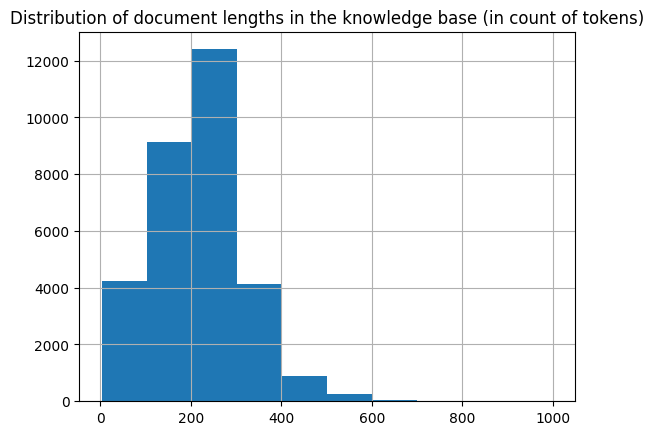

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/16776 [00:00<?, ?it/s]

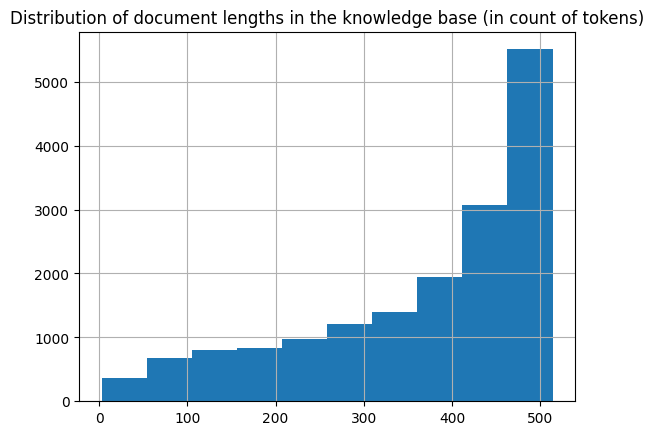

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### Building the vector database

We want to compute the embeddings for all the chunks of our knowledge base: to learn more about sentence embeddings, we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

Regarding distances, you can find a good guide [here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings). In short:

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

You can try [this small exercise](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding) to check your understanding of these concepts. But once vectors are normalized, [the choice of a specific distance does not matter much](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use).

Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

🚨👇 The cell below takes a few minutes to run on A10G!

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

C:\Users\USERAS\AppData\Local\Temp\ipykernel_9700\789955820.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [ ]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/PaCMAP_embeddings.png" height="700">

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}


In [ ]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

In [ ]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]

context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

'\nExtracted documents:\nDocument 0:::\n```\n</tf>\n</frameworkcontent>\n\n## Pipeline\n\n<Youtube id="tiZFewofSLM"/>\n\nThe [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:\n\n<Tip>\n\nFor a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).\n\n</Tip>Document 1:::\n```\n\n2. Pass a prompt to the pipeline to generate an image:\n\n```py\nimage = pipeline(\n\t"stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k"\n).images[0]\nimageDocument 2:::\n- Pipelines should be very readable, self-explanatory, and easy to tweak.\n- Pipelines should be designed to build on top of each other and be easy to integrate into higher-level APIs.\n- Pipelines are **not** intended to be feature-complete user interfaces. For future complete user interfac

In [ ]:
prompt_in_chat_format = [
    {
        "role": "developer",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": f"""Context:
{context}
---
Now here is the question you need to answer.

Question: {user_query}""",
    },
]

[{'role': 'developer',
  'content': 'Using the information contained in the context,\ngive a comprehensive answer to the question.\nRespond only to the question asked, response should be concise and relevant to the question.\nProvide the number of the source document when relevant.\nIf the answer cannot be deduced from the context, do not give an answer.'},
 {'role': 'user',
  'content': 'Context:\n\nExtracted documents:\nDocument 0:::\n```\n</tf>\n</frameworkcontent>\n\n## Pipeline\n\n<Youtube id="tiZFewofSLM"/>\n\nThe [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:\n\n<Tip>\n\nFor a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).\n\n</Tip>Document 1:::\n```\n\n2. Pass a prompt to the pipeline to generate an image:\n\n```py\nimage = pipeline(\n\t"stained glass of dart

In [ ]:
completion = client.responses.create(
    model="openai/gpt-oss-120b:free",
    input="How to create a pipeline object?"
)

print(completion.output_text)

Below is a quick‑start guide that shows how to **create a pipeline object** in a few of the most common environments where the term “pipeline” is used. Pick the one that matches the stack you’re working with, copy the snippet, and adapt it to your own data or tasks.

---

## 1️⃣ Scikit‑Learn (Machine‑Learning preprocessing + model pipeline)

```python
# Install if you don’t have it yet
# pip install scikit-learn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# ------------------------------
# 1️⃣  Define your raw data
# ------------------------------
df = pd.read_csv("my_data.csv")
X = df.drop("target", axis=1)
y = df["target"]

# ------------------------------
# 2️⃣  Declare which columns need which preprocessing
# ------------------------------
numeric_features = ["age", "salary"]
categorical_features = ["city",

In [34]:
completion = client.responses.create(
    model="openai/gpt-oss-120b:free",
    input=prompt_in_chat_format
)

print(completion.output_text)

To create a pipeline object you need to:

1. **Choose the base class** – for most diffusion‑based tasks inherit from `diffusers.DiffusionPipeline` (or from `transformers.Pipeline` for generic tasks)【Document 3】.  

2. **Define the required methods** – implement  
   * `preprocess` (turn raw inputs into model‑ready tensors)  
   * `_forward` (run the model)  
   * `postprocess` (convert model outputs to the final format)  
   * `_sanitize_parameters` (handle optional arguments)【Document 3】.  

   Example skeleton:

   ```python
   from transformers import Pipeline

   class MyPipeline(Pipeline):
       def _sanitize_parameters(self, **kwargs):
           preprocess_kwargs = {}
           if "maybe_arg" in kwargs:
               preprocess_kwargs["maybe_arg"] = kwargs["maybe_arg"]
           return preprocess_kwargs, {}, {}

       def preprocess(self, inputs, maybe_arg=2):
           model_input = Tensor(inputs["input_ids"])
           return {"model_input": model_input}
   ```

3. **In

In [65]:
from pylate import models

RERANKER = models.ColBERT("colbert-ir/colbertv2.0")

No sentence-transformers model found with name colbert-ir/colbertv2.0.


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

C:\Users\USERAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USERAS\.cache\huggingface\hub\models--colbert-ir--colbertv2.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

artifact.metadata: 0.00B [00:00, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [114]:
def rerank_docs(
        queries,
        documents_id,
        documents,
) -> List[str]:
        query_embeddings = RERANKER.encode(
                queries,
                is_query=True,
        )

        documents_embeddings = RERANKER.encode(
                documents,
                is_query=False,
        )

        reranked_documents = rank.rerank(
                documents_ids=documents_id,
                queries_embeddings=query_embeddings,
                documents_embeddings=documents_embeddings,
        )
        
        top_docs = [
                doc 
                for id, doc in zip(documents_id, documents) 
                if reranked_documents[0][0]['id'] == id
        ]

        return top_docs

In [ ]:
from transformers import Pipeline
from sentence_transformers import SentenceTransformer

def generate_answer(
        user_query,
        context
) -> str:
    prompt_in_chat_format = [
        {
            "role": "developer",
            "content": """Using the information contained in the context,
    give a comprehensive answer to the question.
    Respond only to the question asked, response should be concise and relevant to the question.
    Provide the number of the source document when relevant.
    If the answer cannot be deduced from the context, do not give an answer.""",
        },
        {
            "role": "user",
            "content": f"""Context:
    {context}
    ---
    Now here is the question you need to answer.

    Question: {user_query}""",
        },
    ]

    completion = client.responses.create(
        model="openai/gpt-oss-120b:free",
        input=prompt_in_chat_format
    )

    return completion.output_text

def answer_with_rag(
    question: str,
    knowledge_index: FAISS,
    reranker: Optional[SentenceTransformer] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 1,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [[doc.page_content] for doc in relevant_docs]  # Keep only the text

    relevant_docs_id = [[doc.id] for doc in retrieved_docs]

    query = [question]

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = rerank_docs(query, relevant_docs_id, relevant_docs)
    #     relevant_docs = [doc["content"] for doc in relevant_docs]

    # relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    # Redact an answer
    print("=> Generating answer...")
    answer = generate_answer(question, context)

    return answer, relevant_docs

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...


In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)